## This notebook implements extraction methods for the custom data files

The goal is to extract the order parameters from the simulation files.

Custom extraction methods are provided.

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

## File name

Files are provided in .xyz files. The filename contains various information. The syntax is as follows:

```allParticles_mode_RadiusAndOrK_N_L_v_t_noise.xyz```

where:

* ```allParticles``` is the prefix of the file
* ```mode``` is the mode of the simulation, with:
    * ```kNeighbors``` for fixed k-nearest neighbors
    * ```rRadius``` for dynamic neighbors within a fixed radius
    * ```rkFixedRadius``` for k-nearest neighbors within a fixed radius
* ```RadiusAndOrK``` provides the number of neighbors (k) or the radius (r) used in the simulation, with:
    * ```k#``` for k-nearest neighbors
    * ```r#``` for a fixed radius
    * ```r#_k#``` for k-nearest neighbors within a fixed radius
* ```N``` is the number of particles
* ```L``` is the length of the box (system size)
* ```v``` is the velocity of the particles
* ```t``` is the total timesteps of the simulation
* ```noise``` is the noise level of the simulation, where:
    * ```noise#```, # is the noise level. `0` and `5` are hit directly; the other values are ``floats`` with variable lenghts.

**Example (filename)**

*kNeighbors*
```
allParticles_kNeighbors_k10_N400_L10_v0.03_t40000_noise5.xyz
```

or

*rkFixedRadius*
```
allParticles_rkFixedRadius_r1_k10_N100_L5_v0.03_t40000_noise4.583333.xyz
```

or 
    
*rRadius*
```
allParticles_rRadius_r1_N400_L10_v0.03_t40000_noise3.75.xyz
```

## File format

The files themselves contain the following information:

Header (as string): ``N``, ``L``, ``v``, ``noise``, ``r``, ``mode``, ``k``, ``ZDimension``, ``seed``, ``sweeps``, ``timesteps``

Followed by a line with exactly these informaion.

After this, the positions (x,y) and the angles of the particles (`0 <= angle < 2pi`) are provided in a usual .xyz format. This means that for every sweep, the positions and angles of all particles are provided, preceeded by the current sweep count.

**Example (content of a file)**

```python
N, L, v, noise, r, mode, k, ZDimension, seed, sweeps, timesteps
400,10,0.03,5,1,1,10,0,1,100,40000

0
6.70553,2.99917,1.78992
9.13041,0.143051,3.52682
1.43911,4.10906,4.81116
4.41873,4.18801,2.06869
9.80442,9.03304,3.21041
...
```

## Procedure

Three steps:
1. Extract and prepare the data
2. Calculate the order parameters
3. Save the data to a file (effectively storing a plot in a file)

### Extract and prepare the data

Each simulation (file) produces an order parameter, which is to be stored.

So the `extraction` and `calculation` methods are modular.

In [2]:
def extractData(filename: str,
                getDataFromHeader: bool = False, parametersOnly: bool = False):
    """
    Extracts all data from a simulation file.
    
    Timing
    ------
    Roughly 90 ms for the biggest file (80000 lines).
    
    There are 4 Types of simulations, 3 with 40000 lines and 1 with 80000 lines.
    For rounding up to 100 ms, there is a total time of 250 ms for reading the files, per 4 setting types.
    
    Of 2100 files (4 settings, 10 values for k, 25 noise levels), there are 525 files per setting group.
    So we have 525 * 250 ms = 131.25 s = 2.1875 min for just reading the data.
    
    Parameters
    ----------
    filename : str
        Path to the simulation file.
    getDataFromHeader : bool, optional
        If True, the data is extracted from the header of the file. Otherwise, the data is extracted from the file name.

    Returns
    -------
    np.ndarray
        Array with the data from the simulation file.
        Format:
            `[ foreach sweep [x_positions] , [y_positions] , [angles]]`
    dict
        Dictionary with the parameters of the simulation.
        
    Examples
    --------
    >>> data, parameters = extractData("allParticles_kNeighbors_k1_N100_L5.5_v0.03_t80000_noise0.xyz")
    >>> print(parameters)
    {'r': 1, 'k': 1, 'N': 100, 'L': 5.5, 'v': 0.03, 't': 80000, 'n': 0.0, 'mode': 'kNeighbors'}
    
    >>> data, parameters = extractData("allParticles_kNeighbors_k10_N1600_L20_v0.03_t80000_noise0.28572.xyz")
    >>> print(parameters)
    {'r': 1, 'k': 10, 'N': 1600, 'L': 20.0, 'v': 0.03, 't': 80000, 'n': 0.28572, 'mode': 'kNeighbors'}
    
    >>> data, parameters = extractData("allParticles_rkFixedRadius_r1_k9_N400_L10_v0.03_t40000_noise0.625.xyz")
    >>> print(parameters)
    {'r': 1, 'k': 9, 'N': 400, 'L': 10.0, 'v': 0.03, 't': 40000, 'n': 0.625, 'mode': 'rkFixedRadius'}
    
    >>> data, parameters = extractData("allParticles_rRadius_r1_N400_L10_v0.03_t40000_noise0.625.xyz") 
    >>> print(parameters)
    {'r': 1, 'k': 0, 'N': 400, 'L': 10.0, 'v': 0.03, 't': 40000, 'n': 0.625, 'mode': 'rRadius'}
    
    """
    
    # [ ] Implement reading from the header instead of the file name
    
    # Extract parameters from the file name
    filename_split = filename.split('_')
    
    # Throw away all strings before the string that contains "allParticles" (folder names can contain underscores)
    while "allParticles" not in filename_split[0]:
        filename_split.pop(0)
        
    # Remove the .xyz
    last_split = filename_split[-1].split('.')
    last_split.pop()
    filename_split[-1] = '.'.join(last_split)
    
    mode = filename_split[1]
    r = N = L = v = t = n = 1
    k = 0
    parameters = {}
    
    if mode == 'kNeighbors':
        # Clean the strings
        filename_split[2] = filename_split[2].replace('k', '')
        filename_split[3] = filename_split[3].replace('N', '')
        filename_split[4] = filename_split[4].replace('L', '')
        filename_split[5] = filename_split[5].replace('v', '')
        filename_split[6] = filename_split[6].replace('t', '')
        filename_split[7] = filename_split[7].replace('noise', '')

        # Convert to the correct type
        k = int(filename_split[2])
        N = int(filename_split[3])
        L = float(filename_split[4])
        v = float(filename_split[5])
        t = int(filename_split[6])
        n = float(filename_split[7])
        
        # Save as a dictionary
        parameters = {
            'r': r,
            'k': k,
            'N': N,
            'L': L,
            'v': v,
            't': t,
            'n': n,
            'mode': mode
        }

    elif mode == 'rRadius':
        # Clean the strings
        filename_split[2] = filename_split[2].replace('r', '')
        filename_split[3] = filename_split[3].replace('N', '')
        filename_split[4] = filename_split[4].replace('L', '')
        filename_split[5] = filename_split[5].replace('v', '')
        filename_split[6] = filename_split[6].replace('t', '')
        filename_split[7] = filename_split[7].replace('noise', '')

        # Convert to the correct type
        r = int(filename_split[2])
        N = int(filename_split[3])
        L = float(filename_split[4])
        v = float(filename_split[5])
        t = int(filename_split[6])
        n = float(filename_split[7])
        
        # Save as a dictionary
        parameters = {
            'r': r,
            'k': k,
            'N': N,
            'L': L,
            'v': v,
            't': t,
            'n': n,
            'mode': mode
        }
        
    elif mode == 'rkFixedRadius':
        # Clean the strings
        filename_split[2] = filename_split[2].replace('r', '')
        filename_split[3] = filename_split[3].replace('k', '')
        filename_split[4] = filename_split[4].replace('N', '')
        filename_split[5] = filename_split[5].replace('L', '')
        filename_split[6] = filename_split[6].replace('v', '')
        filename_split[7] = filename_split[7].replace('t', '')
        filename_split[8] = filename_split[8].replace('noise', '')

        # Convert to the correct type
        r = int(filename_split[2])
        k = int(filename_split[3])
        N = int(filename_split[4])
        L = float(filename_split[5])
        v = float(filename_split[6])
        t = int(filename_split[7])
        n = float(filename_split[8])
        
        # Save as a dictionary
        parameters = {
            'r': r,
            'k': k,
            'N': N,
            'L': L,
            'v': v,
            't': t,
            'n': n,
            'mode': mode
        }
        
    if parametersOnly:
        print(parameters)
        return [], parameters
    
    # Extract data from the file
    # Create numpy array in the format [ foreach sweep [x_positions] , [y_positions] , [angles]]
    data = np.empty((t // N, 3, N))
    
    with open(filename, 'r') as f:
        turnover = False
        x = np.empty(N)
        y = np.empty(N)
        angles = np.empty(N)
        index = 0
        for i, line in enumerate(f):
            # Skip the first two lines
            if i < 2:
                continue
            
            if line == '\n':
                # Skip the next line
                turnover = True
                continue
            elif turnover:
                # Skip this line
                turnover = False
                continue
            else:
                # Extract the data
                line_split = line.split(',')
                x[index % N] = float(line_split[0])
                y[index % N] = float(line_split[1])
                angles[index % N] = float(line_split[2])
                
                # Save the data
                if index % N == N - 1:
                    data[(index // N)] = np.array([x, y, angles], copy=True)
                    x = np.empty(N)
                    y = np.empty(N)
                    angles = np.empty(N)
                    
                index += 1
    
    return data, parameters
    

### Testing parameter extraction

In [3]:
extractData("allParticles_kNeighbors_k1_N100_L5.5_v0.03_t80000_noise0.xyz", parametersOnly=True)
extractData("allParticles_kNeighbors_k10_N1600_L20_v0.03_t80000_noise0.28572.xyz", parametersOnly=True)
extractData("allParticles_rkFixedRadius_r1_k9_N400_L10_v0.03_t40000_noise0.625.xyz", parametersOnly=True)
extractData("allParticles_rRadius_r1_N400_L10_v0.03_t40000_noise0.625.xyz", parametersOnly=True)
print("Done")

{'r': 1, 'k': 1, 'N': 100, 'L': 5.5, 'v': 0.03, 't': 80000, 'n': 0.0, 'mode': 'kNeighbors'}
{'r': 1, 'k': 10, 'N': 1600, 'L': 20.0, 'v': 0.03, 't': 80000, 'n': 0.28572, 'mode': 'kNeighbors'}
{'r': 1, 'k': 9, 'N': 400, 'L': 10.0, 'v': 0.03, 't': 40000, 'n': 0.625, 'mode': 'rkFixedRadius'}
{'r': 1, 'k': 0, 'N': 400, 'L': 10.0, 'v': 0.03, 't': 40000, 'n': 0.625, 'mode': 'rRadius'}
Done


In [4]:
# # Time the code
# import time
# start_time = time.time()
# filename = "allParticles_kNeighbors_k1_N1600_L20_v0.03_t80000_noise1.25.xyz"
# path = "../data/FullSimulations/" + filename
# data, parameters = extractData(path)
# print("--- %s seconds ---" % (time.time() - start_time))


### Define methods for the order parameters

In [5]:
def getVicsekOP(data: np.ndarray, parameters: dict):
    """
    Calculate the Vicsek order parameter for a given data set.
    """
    
    vicsekOP = 0.0

    # Average over the last x percent of sweeps
    x = 0.8
    sweeps = parameters["t"] // parameters["N"]
    averagingSweeps = sweeps * x
    
    # print(data)
    # print(data.shape)
    
    # Calculate the order parameter
    for sweep in range(int(sweeps - averagingSweeps), sweeps):
        
        cosSum = 0.0
        sinSum = 0.0
        
        sweepData = data[sweep, :, :]
        
        for particle in np.transpose(sweepData):
            cosSum += np.cos(particle[2])
            sinSum += np.sin(particle[2])
            
        vicsekOP += np.sqrt(cosSum**2 + sinSum**2) / parameters["N"]
        
    vicsekOP /= averagingSweeps
    
    return vicsekOP

In [6]:
def getFlockingOP():
    return None

### Testing the order parameter

In [7]:
# Test some order parameters

# Should be close to 1
print(getVicsekOP(*extractData("../data/Fullsimulations/noiseVariation_fixedDensity/allParticles_rkFixedRadius_r1_k10_N40_L3.1_v0.03_t40000_noise0.xyz")))

# Should be close to 0
print(getVicsekOP(*extractData("../data/Fullsimulations/noiseVariation_fixedDensity/allParticles_rkFixedRadius_r1_k10_N1600_L20_v0.03_t80000_noise5.xyz")))

1.0
0.02901183598997805


In [8]:
def saveOPtoFile(data: np.ndarray, filename: str, checkDoubles: bool, targetPath: str):
    # Check if file exists
    # Use checkDoubles to either overwrite the file or only print the status
    
    if checkDoubles:
        if os.path.isfile(targetPath + filename):
            print(filename + " already exists")
            return False
    
    # Save data to file
    with open(targetPath + filename + ".txt", "wb") as f:
        # Write file, where data[0], data[1], data[2] are 1D arrays and represent the columns
        np.savetxt(f, np.transpose(data), delimiter=",", fmt="%s")
            
    return True

In [9]:
def VicsekOP_noise(path: str, targetPath: str,
                   checkDoubles: bool = False, mode: str = "all", k: int = -1):
    """
    Calculate the Vicsek order parameter for a given path of files.
    
    Parameters
    ----------
    path : str
        Path to the files.
    targetPath : str
        Path for writing the file.
    checkDoubles : bool, optional
        Check if the file/plot to write already exists. Only calculates new data.
    mode : str, optional
        Mode for the calculation. Can be "all", "k", "r" or "rk".
    k : int, optional
        The k value for the calculation. Only used if mode is "k" or "rk".
        
        Default is -1, which means all k values.
    
    Returns
    -------
    None
    """
    # [ ] Add parameter for the order parameter function
    
    # Get all the files in the path
    files = os.listdir(path)
    files.sort()
    
    # The plots are grouped for k
    # Collect and group all data for each k
    
    data_final = []
    N_array = []
    n_array = []
    op_array = []
    
    last_r, last_k = 0, 0
    last_mode = ""
    
    writingCounter = 0
    
    for i, file in enumerate(files):
        
        # Print progress (in %)
        print(f"\rFiles written: {writingCounter} ({(i+1)/len(files)*100:.2f}%)", end="")
        # Get the data and parameters
        data, parameters = extractData(path + file)
        
        # Create new file name
        fileName = "VicsekOPnoise_"
        fileName += parameters["mode"]
        if parameters["mode"] == "kNeighbors":
            fileName += "_k" + str(parameters["k"])
        elif parameters["mode"] == "rRadius":
            fileName += "_r" + str(parameters["r"])
        elif parameters["mode"] == "rkFixedRadius":
            fileName += "_r" + str(parameters["r"]) + "_k" + str(parameters["k"])
        # Add density (round to 2 decimals)
        rho = parameters["N"] / parameters["L"]**2
        fileName += "_rho" + str(round(rho, 2))
        
        vicsekOP = getVicsekOP(data, parameters)
        
        # The files are sorted, so each k group is consecutive
        # For each k, there are 4 setting groups (differ in N and L (and t))
        # Proceed as follows:
        # 1. Check if the mode has changed. If so, write the data to a file and reset the data.
        # 2. (If mode has not changed) Check if r and/or k has changed. If so, write the data to a file and reset the data.
        # Depending on the mode, check for either or both.
        
        r = parameters["r"]
        k = parameters["k"]
        simulation_mode = parameters["mode"]
        
        if simulation_mode == "kNeighbors":
            if last_mode != simulation_mode or last_k != k:
                if i != 0:
                    data_final = np.array([N_array, n_array, op_array])
                    written = saveOPtoFile(data_final, fileName, checkDoubles, targetPath)
                    if written:
                        writingCounter += 1
                    N_array = []
                    n_array = []
                    op_array = []
            else:
                N_array.append(parameters["N"])
                n_array.append(parameters["n"])
                op_array.append(vicsekOP)
                
        elif simulation_mode == "rRadius":
            if last_mode != simulation_mode or last_r != r:
                if i != 0:
                    data_final = np.array([N_array, n_array, op_array])
                    written = saveOPtoFile(data_final, fileName, checkDoubles, targetPath)
                    if written:
                        writingCounter += 1
                    N_array = []
                    n_array = []
                    op_array = []
                    
            else:
                N_array.append(parameters["N"])
                n_array.append(parameters["n"])
                op_array.append(vicsekOP)
            
        elif simulation_mode == "rkFixedRadius":
            if last_mode != simulation_mode or last_k != k or last_r != r:
                if i != 0:
                    data_final = np.array([N_array, n_array, op_array]) 
                    written = saveOPtoFile(data_final, fileName, checkDoubles, targetPath)
                    if written:
                        writingCounter += 1
                    N_array = []
                    n_array = []
                    op_array = []
                    
            else:
                N_array.append(parameters["N"])
                n_array.append(parameters["n"])
                op_array.append(vicsekOP)
            
        last_r = r
        last_k = k
        last_mode = simulation_mode

    print()

In [10]:
pathSourceNoised = "../data/Fullsimulations/noiseVariation_fixedDensity/"
VicsekOP_noise(pathSourceNoised, "../data/OrderParameters/VicsekOP_noises/")

Files written: 1 (6.71%)

KeyboardInterrupt: 

# Averaging analysis
How many sweeps do we need to average over to get a good estimate of the order parameter?

To answer this question, we will look at the standard deviation and `mean of the order parameter as a function of the number of sweeps we average over`.

For a rough estimate, we only average over the following settings:

**Fixed neighbors**
* k = 1 and k = 8
    * Low and high noise
        * Low and high particle number 

**Dynamic model**
* k = 1 and k = 8
    * Low and high noise
        * Low and high particle number

**Radius model**
* Low and high noise
    * Low and high particle number

In total, we have ``20 settings`` to average over.

In [11]:
fileNames_kNeighbors = ["allParticles_kNeighbors_k1_N40_L3.1_v0.03_t40000_noise0.208333.xyz",  "allParticles_kNeighbors_k1_N40_L3.1_v0.03_t40000_noise3.125.xyz",
                        "allParticles_kNeighbors_k1_N1600_L20_v0.03_t80000_noise0.xyz", "allParticles_kNeighbors_k1_N1600_L20_v0.03_t80000_noise3.125.xyz",
                        "allParticles_kNeighbors_k8_N40_L3.1_v0.03_t40000_noise0.208333.xyz",  "allParticles_kNeighbors_k8_N40_L3.1_v0.03_t40000_noise3.125.xyz",
                        "allParticles_kNeighbors_k8_N1600_L20_v0.03_t80000_noise0.xyz", "allParticles_kNeighbors_k8_N1600_L20_v0.03_t80000_noise3.125.xyz",
                        "allParticles_kNeighbors_k1_N100_L5_v0.03_t40000_noise0.208333.xyz",  "allParticles_kNeighbors_k1_N100_L5_v0.03_t40000_noise3.125.xyz",
                        "allParticles_kNeighbors_k1_N400_L10_v0.03_t40000_noise0.208333.xyz", "allParticles_kNeighbors_k1_N400_L10_v0.03_t40000_noise3.125.xyz",
                        "allParticles_kNeighbors_k8_N100_L5_v0.03_t40000_noise0.208333.xyz",  "allParticles_kNeighbors_k8_N100_L5_v0.03_t40000_noise3.125.xyz",
                        "allParticles_kNeighbors_k8_N400_L10_v0.03_t40000_noise0.208333.xyz", "allParticles_kNeighbors_k8_N400_L10_v0.03_t40000_noise3.125.xyz"]

fileNames_rkFixedRadius = [ "allParticles_rkFixedRadius_r1_k1_N40_L3.1_v0.03_t40000_noise0.xyz",  "allParticles_rkFixedRadius_r1_k1_N40_L3.1_v0.03_t40000_noise3.125.xyz",
                            "allParticles_rkFixedRadius_r1_k1_N1600_L20_v0.03_t80000_noise0.xyz", "allParticles_rkFixedRadius_r1_k1_N1600_L20_v0.03_t80000_noise3.125.xyz",
                            "allParticles_rkFixedRadius_r1_k8_N40_L3.1_v0.03_t40000_noise0.xyz",  "allParticles_rkFixedRadius_r1_k8_N40_L3.1_v0.03_t40000_noise3.125.xyz",
                            "allParticles_rkFixedRadius_r1_k8_N1600_L20_v0.03_t80000_noise0.xyz", "allParticles_rkFixedRadius_r1_k8_N1600_L20_v0.03_t80000_noise3.125.xyz",
                            "allParticles_rkFixedRadius_r1_k1_N100_L5_v0.03_t40000_noise0.xyz",  "allParticles_rkFixedRadius_r1_k1_N100_L5_v0.03_t40000_noise3.125.xyz",
                            "allParticles_rkFixedRadius_r1_k1_N400_L10_v0.03_t40000_noise0.xyz", "allParticles_rkFixedRadius_r1_k1_N400_L10_v0.03_t40000_noise3.125.xyz",
                            "allParticles_rkFixedRadius_r1_k8_N100_L5_v0.03_t40000_noise0.xyz",  "allParticles_rkFixedRadius_r1_k8_N100_L5_v0.03_t40000_noise3.125.xyz",
                            "allParticles_rkFixedRadius_r1_k8_N400_L10_v0.03_t40000_noise0.xyz", "allParticles_rkFixedRadius_r1_k8_N400_L10_v0.03_t40000_noise3.125.xyz"]

fileNames_rRadius = [   "allParticles_rRadius_r1_N40_L3.1_v0.03_t40000_noise0.xyz",  "allParticles_rRadius_r1_N40_L3.1_v0.03_t40000_noise3.125.xyz",
                        "allParticles_rRadius_r1_N1600_L20_v0.03_t80000_noise0.xyz", "allParticles_rRadius_r1_N1600_L20_v0.03_t80000_noise3.125.xyz"]

In [12]:
def getDynamicVicsekOP(data: np.ndarray, parameters: dict):
    """
    Calculate the Vicsek order parameter (mean and std) as a function of sweeps.
    """
    
    sweeps = parameters["t"] // parameters["N"]
    
    # Initialize arrays
    vicsekOP = np.zeros(sweeps)
    cumulativeOPMean = np.zeros(sweeps)

    # Calculate the order parameter
    for i in range(sweeps):
        cosSum = np.cos(data[sweeps-1-i, 2, :]).sum()
        sinSum = np.sin(data[sweeps-1-i, 2, :]).sum()
        vicsekOP[i] = np.sqrt(cosSum**2 + sinSum**2) / parameters["N"]

    # Calculate cumulative mean and std
    cumulativeOPMean = np.array([np.mean(vicsekOP[:i+1]) for i in range(sweeps)])
    cumulativeOPStd = np.array([np.std(vicsekOP[:i+1]) for i in range(sweeps)])

    return cumulativeOPMean, cumulativeOPStd, vicsekOP

In [13]:
import matplotlib.pyplot as plt

def analyse_averages(files: str, targetPath: str, path: str, rows: int, cols: int):
    
    # Initialize a figure
    fig, axs = plt.subplots(rows, cols, figsize=(6*cols, 6*rows))  # Adjust size as needed
    
    for i, file in enumerate(files):
        
        # Get the data and parameters
        data, parameters = extractData(path + file)
        
        cumulativeOPMean, cumulativeOPStd, vicsekOP = getDynamicVicsekOP(data, parameters)
        
        mode = parameters['mode']

        # Calculate the row and column indices for the subplot
        row = i // cols
        col = i % cols

        if mode == "kNeighbors":
            # Plot all 8 settings in a single plot, 2x4
            axs[row, col].plot(cumulativeOPMean, label='Cumulative mean')
            axs[row, col].plot(vicsekOP, '.', label='Order Parameter', markersize=1)
            axs[row, col].fill_between(range(len(cumulativeOPMean)), cumulativeOPMean - cumulativeOPStd, cumulativeOPMean + cumulativeOPStd, alpha=0.2)

        elif mode == "rkFixedRadius":
            # Plot all 8 settings in a single plot, 2x4
            axs[row, col].plot(cumulativeOPMean, label='Cumulative mean')
            axs[row, col].plot(vicsekOP, '.',  label='Order Parameter', markersize=1)
            axs[row, col].fill_between(range(len(cumulativeOPMean)), cumulativeOPMean - cumulativeOPStd, cumulativeOPMean + cumulativeOPStd, alpha=0.2)

        elif mode == "rRadius":
            # Plot all 4 settings in a single plot, 2x2
            axs[row, col].plot(cumulativeOPMean, label='Cumulative mean')
            axs[row, col].plot(vicsekOP, '.',  label='Order Parameter', markersize=1)
            axs[row, col].fill_between(range(len(cumulativeOPMean)), cumulativeOPMean - cumulativeOPStd, cumulativeOPMean + cumulativeOPStd, alpha=0.2)

        # Add settings to the title (N, L, n, k)
        axs[row, col].set_title(f'{mode}\nN={parameters["N"]}, L={parameters["L"]}, n={parameters["n"]}, k={parameters["k"]}')
        axs[row, col].set_xlabel('# sweeps')
        axs[row, col].set_ylabel('Cumulative Mean')
        axs[row, col].set_ylim([0, 1.1])
        # Draw horizontal line at 1
        axs[row, col].axhline(y=1, color='C2', linestyle='--', label='Reference Line')
        axs[row, col].legend()
    # Adjust the layout and show the plot
    plt.suptitle(f'Order Parameter Averaging Analysis', fontsize=22)
    plt.tight_layout()
    plt.show()


In [14]:
def analyse_average_single(file: str, targetPath: str, path: str):
    
    # Initialize a figure
    fig, axs = plt.subplots(figsize=(15, 10))  # Adjust size as needed
    
    # Get the data and parameters
    data, parameters = extractData(path + file)
    
    cumulativeOPMean, cumulativeOPStd, vicsekOP = getDynamicVicsekOP(data, parameters)
    
    mode = parameters['mode']

    # Plot all 8 settings in a single plot, 2x4
    axs.plot(cumulativeOPMean, label='Cumulative mean')
    axs.plot(vicsekOP, '.', label='Order Parameter', markersize=1)
    axs.fill_between(range(len(cumulativeOPMean)), cumulativeOPMean - cumulativeOPStd, cumulativeOPMean + cumulativeOPStd, alpha=0.2)

    # Add settings to the title (N, L, n, k)
    axs.set_title(f'{mode}\nN={parameters["N"]}, L={parameters["L"]}, n={parameters["n"]}, k={parameters["k"]}')
    axs.set_xlabel('# sweeps')
    axs.set_ylabel('Cumulative Mean')
    axs.set_ylim([0, 1.1])
    # Draw horizontal line at 1
    axs.axhline(y=1, color='C2', linestyle='--', label='Reference Line')
    axs.legend()
    
    # Adjust the layout and show the plot
    plt.suptitle(f'Order Parameter Averaging Analysis', fontsize=22)
    plt.tight_layout()
    plt.show()


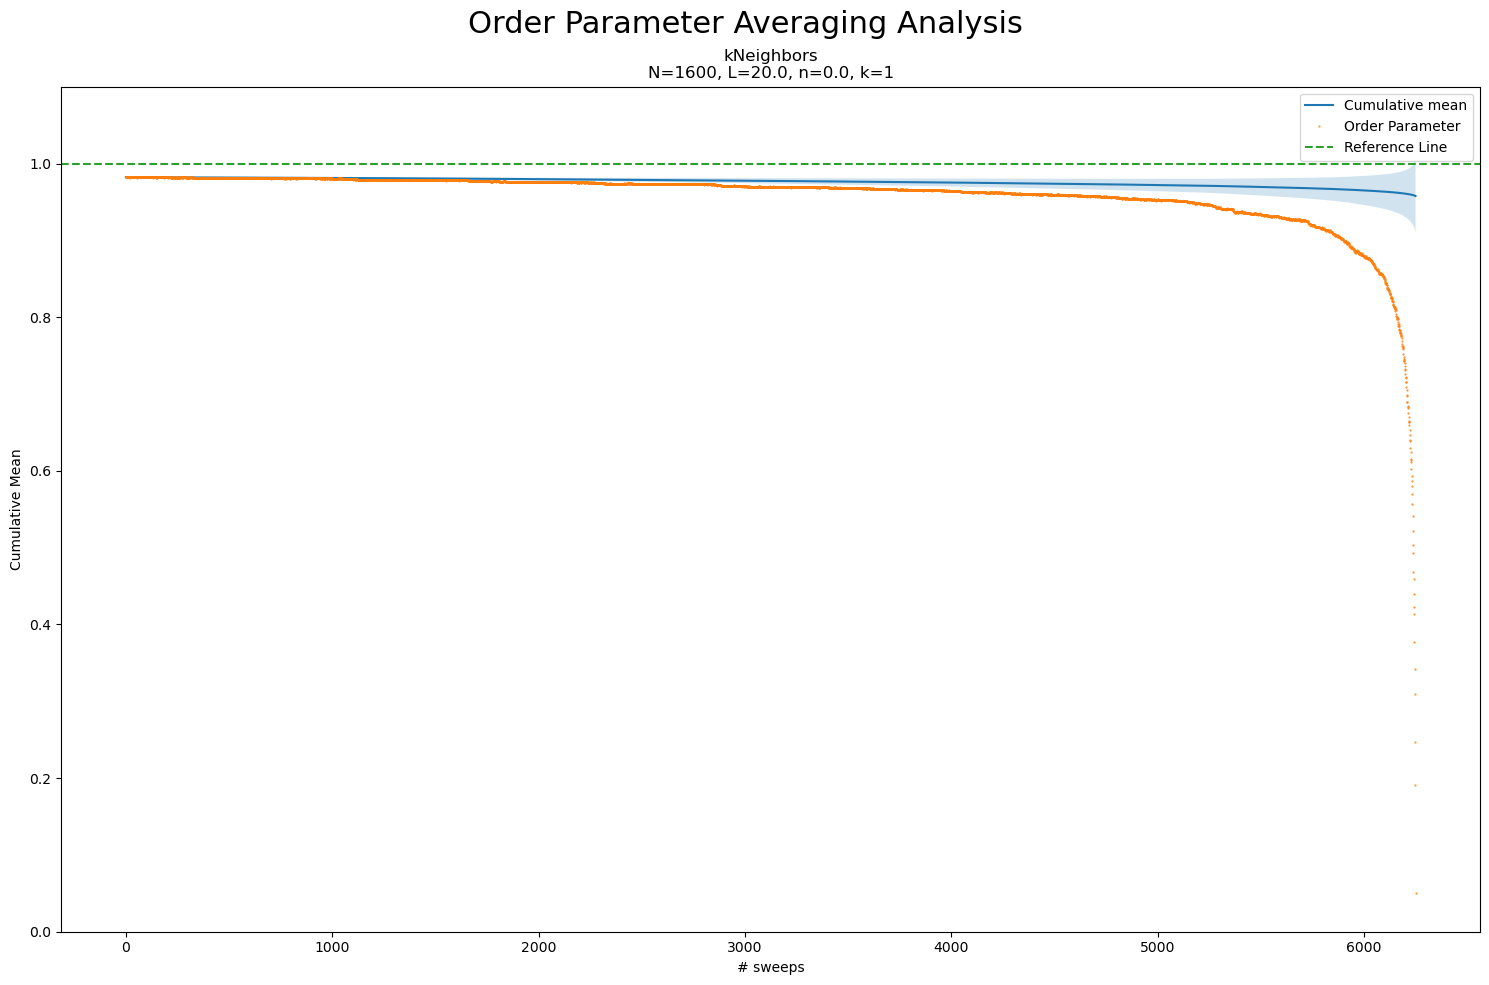

In [15]:
analyse_average_single("allParticles_kNeighbors_k1_N1600_L20_v0.03_t10000000_noise0.xyz", "", pathSourceNoised)

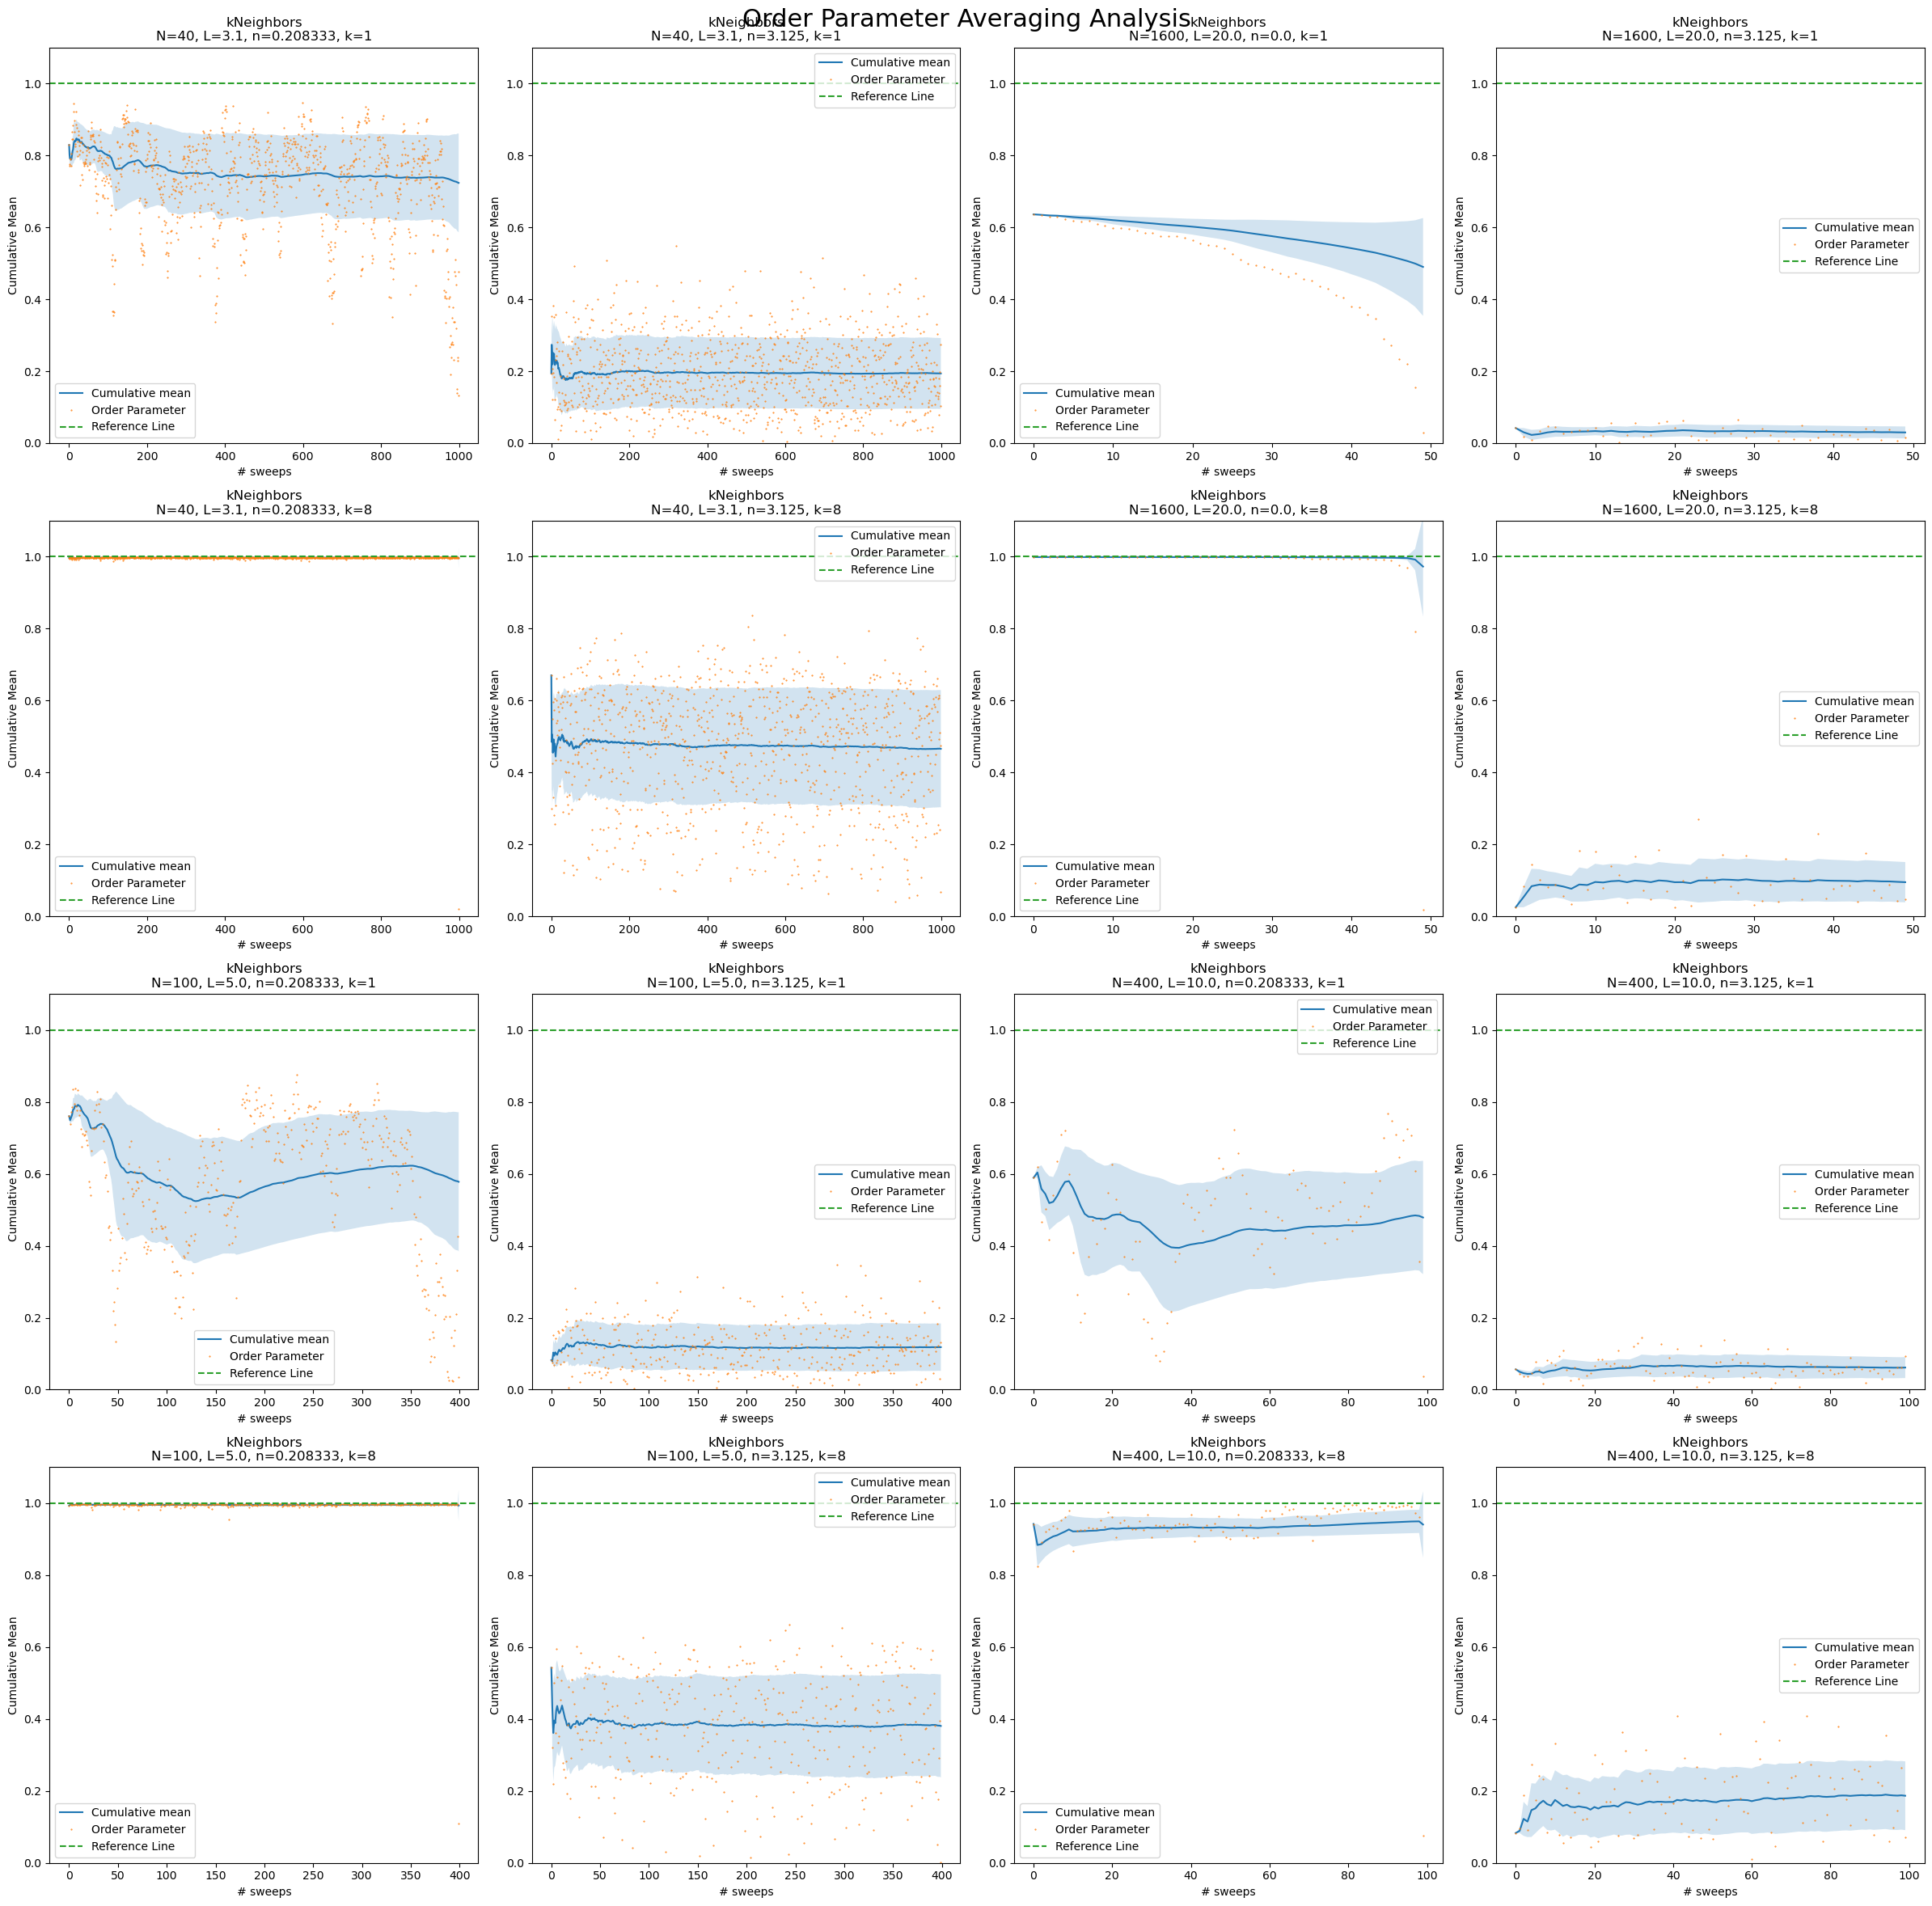

In [16]:
analyse_averages(fileNames_kNeighbors, "", pathSourceNoised, 4, 4)

In [ ]:
analyse_averages(fileNames_rkFixedRadius, "", pathSourceNoised, 4, 4)

In [ ]:
analyse_averages(fileNames_rRadius, "", pathSourceNoised, 2, 4)

# Plotting
## Dynamic Model

In [ ]:
pathOP = "../data/OrderParameters/VicsekOP_noises/"

k_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

fig, axs = plt.subplots(2, 5, figsize=(25, 10))
fig.suptitle("Noise Analysis\nfixed number of neighbors in Radius $r=1$\n" + r"fixed density $\rho = 4$", fontsize=16)

# Define a list of colors to distinguish between the particle groups
colors = ['C0', 'C1', 'C2', 'C3', 'C4']
# Define different markers for the different k values
markers = ['.-', 'x-', '^-', '*-', 'p-']

for j, k in enumerate(k_values):
    # Determine the position of the subplot
    row = j // 5
    col = j % 5

    # Create the file name based on the k value
    filename = pathOP + f"VicsekOPnoise_rkFixedRadius_r1_k{k}_rho4.0.txt"

    N, n, va = np.genfromtxt(filename, delimiter=',', unpack=True, skip_header=True)
    
    # Sort all three arrays by n
    sort_indices = np.argsort(n)
    N = N[sort_indices]
    n = n[sort_indices]
    va = va[sort_indices]

    # Group by N
    unique_N = np.unique(N)
    # Sort values for n
    for index, N_value in enumerate(unique_N):
        mask = N == N_value
        color = colors[index % len(colors)]
        axs[row, col].plot(n[mask], va[mask], markers[index], color=color, label=f'N={N_value}')
        # axs[row, col].fill_between(n[mask], va[mask] - prev[mask], va[mask] + prev[mask], color=color, alpha=0.2)
    
    axs[row, col].set_xlabel(r"$n$")
    axs[row, col].set_ylabel(r"$v_a$")
    axs[row, col].set_ylim((0,1.1))
    axs[row, col].grid()
    axs[row, col].set_title(rf"$k = {k}$")
    axs[row, col].legend()

# Adjust spacing
fig.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

## Fixed Neighbors

In [ ]:
pathOP = "../data/OrderParameters/VicsekOP_noises/"

k_values = [1, 2, 3, 4, 5, 6, 7, 8, 9]

fig, axs = plt.subplots(2, 5, figsize=(25, 10))
fig.suptitle("Noise Analysis\nfixed number of neighbors\n" + r"fixed density $\rho = 4$", fontsize=16)

# Define a list of colors to distinguish between the particle groups
colors = ['C0', 'C1', 'C2', 'C3', 'C4']
# Define different markers for the different k values
markers = ['.-', 'x-', '^-', '*-', 'p-']

for j, k in enumerate(k_values):
    # Determine the position of the subplot
    row = j // 5
    col = j % 5

    # Create the file name based on the k value
    filename = pathOP + f"VicsekOPnoise_kNeighbors_k{k}_rho4.0.txt"

    N, n, va = np.genfromtxt(filename, delimiter=',', unpack=True, skip_header=True)
    
    # Sort all three arrays by n
    sort_indices = np.argsort(n)
    N = N[sort_indices]
    n = n[sort_indices]
    va = va[sort_indices]

    # Group by N
    unique_N = np.unique(N)
    # Sort values for n
    for index, N_value in enumerate(unique_N):
        mask = N == N_value
        color = colors[index % len(colors)]
        axs[row, col].plot(n[mask], va[mask], markers[index], color=color, label=f'N={N_value}')
        # axs[row, col].fill_between(n[mask], va[mask] - prev[mask], va[mask] + prev[mask], color=color, alpha=0.2)
    
    axs[row, col].set_xlabel(r"$n$")
    axs[row, col].set_ylabel(r"$v_a$")
    axs[row, col].set_ylim((0,1.1))
    axs[row, col].grid()
    axs[row, col].set_title(rf"$k = {k}$")
    axs[row, col].legend()

# Adjust spacing
fig.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

## Radius

In [ ]:
pathOP = "../data/OrderParameters/VicsekOP_noises/"

fig, axs = plt.subplots(figsize=(15, 10))
fig.suptitle("Noise Analysis\nRadius $r=1$\n" + r"fixed density $\rho = 4$", fontsize=16)

# Define a list of colors to distinguish between the particle groups
colors = ['C0', 'C1', 'C2', 'C3', 'C4']
# Define different markers for the different k values
markers = ['.-', 'x-', '^-', '*-', 'p-']

# Create the file name based on the k value
filename = pathOP + "VicsekOPnoise_rRadius_r1_rho4.0.txt"

N, n, va = np.genfromtxt(filename, delimiter=',', unpack=True, skip_header=True)

# Sort all three arrays by n
sort_indices = np.argsort(n)
N = N[sort_indices]
n = n[sort_indices]
va = va[sort_indices]

# Group by N
unique_N = np.unique(N)
for index, N_value in enumerate(unique_N):
    mask = N == N_value
    color = colors[index % len(colors)]
    axs.plot(n[mask], va[mask], markers[index], color=color, label=f'N={N_value}')
    # axs[row, col].fill_between(n[mask], va[mask] - prev[mask], va[mask] + prev[mask], color=color, alpha=0.2)
    
axs.set_xlabel(r"$n$")
axs.set_ylabel(r"$v_a$")
axs.set_ylim((0,1.1))
axs.grid()
axs.legend()

# Adjust spacing
fig.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()